In [1]:
# Install required packages (if not already available)
!pip install pandas numpy matplotlib seaborn --quiet

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)

In [21]:
# Upload CSV from your local system
from google.colab import files
uploaded = files.upload()

# Load the dataset
import io
df = pd.read_csv(io.BytesIO(next(iter(uploaded.values()))))

# View basic info
print("Dataset Shape:", df.shape)
df.head(10)

Saving hotel_bookings.csv to hotel_bookings (1).csv
Dataset Shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [4]:
# Check missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])

# Fill numerical column 'children' with median (safe method)
if 'children' in df.columns:
    df['children'] = df['children'].fillna(df['children'].median())

# Fill 'agent' and 'company' with 'Unknown' and ensure they are strings
for col in ['agent', 'company']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str)

# Drop columns with more than 40% missing values
threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Drop any remaining rows with missing values
df = df.dropna()

# Final check
print("Remaining missing values:", df.isnull().sum().sum())

Missing Values:
 children         4
country        488
agent        16340
company     112593
dtype: int64
Remaining missing values: 0


In [5]:
# Drop duplicate rows
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

Removed 31958 duplicate rows.


In [6]:
# Convert date columns to datetime
if 'reservation_status_date' in df.columns:
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Optional: create a full arrival_date if year/month/day provided
if {'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'}.issubset(df.columns):
    df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: str(x))
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' +
        df['arrival_date_month'] + '-' +
        df['arrival_date_day_of_month'].astype(str),
        errors='coerce'
    )

In [7]:
from scipy.stats import zscore

# Detect outliers in selected numeric columns
numeric_cols = ['lead_time', 'adr', 'children']
for col in numeric_cols:
    if col in df.columns:
        z_scores = np.abs(zscore(df[col]))
        df = df[z_scores < 3]  # Keep rows within 3 standard deviations

In [8]:
# Standardize string columns to lowercase
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Rename columns for clarity
df.rename(columns={'is_canceled': 'is_cancelled'}, inplace=True)

In [9]:
# One-hot encoding for nominal categorical columns (e.g., meal, market_segment)
df_encoded = pd.get_dummies(df, drop_first=True)

# Check final dataset shape
print("Final cleaned dataset shape:", df_encoded.shape)
df_encoded.head()

Final cleaned dataset shape: (81899, 925)


,is_cancelled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date,hotel_resort hotel,arrival_date_month_august,arrival_date_month_december,arrival_date_month_february,arrival_date_month_january,arrival_date_month_july,arrival_date_month_june,arrival_date_month_march,arrival_date_month_may,arrival_date_month_november,arrival_date_month_october,arrival_date_month_september,meal_fb,meal_hb,meal_sc,meal_undefined,country_ago,country_alb,country_and,country_are,country_arg,country_arm,country_asm,country_ata,country_atf,country_aus,country_aut,country_aze,country_bdi,country_bel,country_ben,country_bfa,country_bgd,country_bgr,country_bhr,country_bhs,country_bih,country_blr,country_bol,country_bra,country_brb,country_bwa,country_caf,country_che,country_chl,country_chn,country_civ,country_cmr,country_cn,country_col,country_com,country_cpv,country_cri,country_cub,country_cym,country_cyp,country_cze,country_deu,country_dma,country_dnk,country_dom,country_dza,country_ecu,country_egy,country_esp,country_est,country_eth,country_fin,country_fra,country_fro,country_gab,country_gbr,country_geo,country_ggy,country_gha,country_gib,country_glp,country_gnb,country_grc,country_gtm,country_guy,country_hkg,country_hnd,country_hrv,country_hun,country_idn,country_imn,country_ind,country_irl,country_irn,country_irq,country_isl,country_isr,country_ita,country_jam,country_jey,country_jor,country_jpn,country_kaz,country_ken,country_khm,country_kir,country_kna,country_kor,country_kwt,country_lao,country_lbn,country_lby,country_lca,country_lie,country_lka,country_ltu,country_lux,country_lva,country_mac,country_mar,country_mco,country_mdg,country_mdv,country_mex,country_mkd,country_mli,country_mlt,country_mmr,country_mne,country_moz,country_mrt,country_mus,country_mwi,country_mys,country_myt,country_nam,country_ncl,country_nga,country_nic,country_nld,country_nor,country_npl,country_nzl,country_omn,country_pak,country_pan,country_per,country_phl,country_plw,country_pol,country_pri,country_prt,country_pry,country_pyf,country_qat,country_rou,country_rus,country_rwa,country_sau,country_sdn,country_sen,country_sgp,country_sle,country_slv,country_smr,country_srb,country_stp,country_sur,country_svk,country_svn,country_swe,country_syc,country_syr,country_tgo,country_tha,country_tjk,country_tmp,country_tun,country_tur,country_twn,country_tza,country_uga,country_ukr,country_umi,country_ury,country_usa,country_uzb,country_ven,country_vgb,country_vnm,country_zaf,country_zmb,country_zwe,market_segment_complementary,market_segment_corporate,market_segment_direct,market_segment_groups,market_segment_offline ta/to,market_segment_online ta,market_segment_undefined,distribution_channel_direct,distribution_channel_gds,distribution_channel_ta/to,distribution_channel_undefined,reserved_room_type_b,reserved_room_type_c,reserved_room_type_d,reserved_room_type_e,reserved_room_type_f,reserved_room_type_g,reserved_room_type_h,reserved_room_type_l,reserved_room_type_p,assigned_room_type_b,assigned_room_type_c,assigned_room_type_d,assigned_room_type_e,assigned_room_type_f,assigned_room_type_g,assigned_room_type_h,assigned_room_type_i,assigned_room_type_k,assigned_room_type_l,assigned_room_type_p,deposit_type_non refund,deposit_type_refundable,agent_10.0,agent_103.0,agent_104.0,agent_105.0,agent_106.0,agent_107.0,agent_11.0,agent_110.0,agent_111.0,agent_112.0,agent_115.0,agent_117.0,agent_118.0,agent_119.0,agent_12.0,agent_121.0,agent_122.0,agent_126.0,agent_127.0,agent_128.0,agent_129.0,agent_13.0,agent_132.0,agent_133.0,agent_134.0,agent_135.0,agent_138.0,agent_139.0,agent_14.0,agent_141.0,agent_142.0,agent_143.0,agent_144.0,agent_146.0,agent_147.0,agent_148.0,agent_149.0,agent_15.0,agent_1

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Summary info
print(" Dataset Shape:", df.shape)
print("\n Data Types:")
print(df.dtypes)

# Statistical summary
df.describe(include='all').T

 Dataset Shape: (81899, 33)

 Data Types:
hotel                                     object
is_cancelled                               int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type         

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
hotel,81899,2,city hotel,50754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_cancelled,81899.0,NaN,NaN,NaN,0.267757,0.0,0.0,0.0,1.0,1.0,0.442793
lead_time,81899.0,NaN,NaN,NaN,75.996715,0.0,11.0,48.0,121.0,338.0,78.897874
arrival_date_year,81899.0,NaN,NaN,NaN,2016.20369,2015.0,2016.0,2016.0,2017.0,2017.0,0.687273
arrival_date_month,81899,12,august,10118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,81899.0,NaN,NaN,NaN,26.73195,1.0,15.0,27.0,37.0,53.0,13.758982
arrival_date_day_of_month,81899.0,NaN,NaN,NaN,15.785065,1.0,8.0,16.0,23.0,31.0,8.833151
stays_in_weekend_nights,81899.0,NaN,NaN,NaN,1.000427,0.0,0.0,1.0,2.0,16.0,1.025886
stays_in_week_nights,81899.0,NaN,NaN,NaN,2.608029,0.0,1.0,2.0,3.0,41.0,2.039246
adults,81899.0,NaN,NaN,NaN,1.876335,0.0,2.0,2.0,2.0,55.0,0.595488


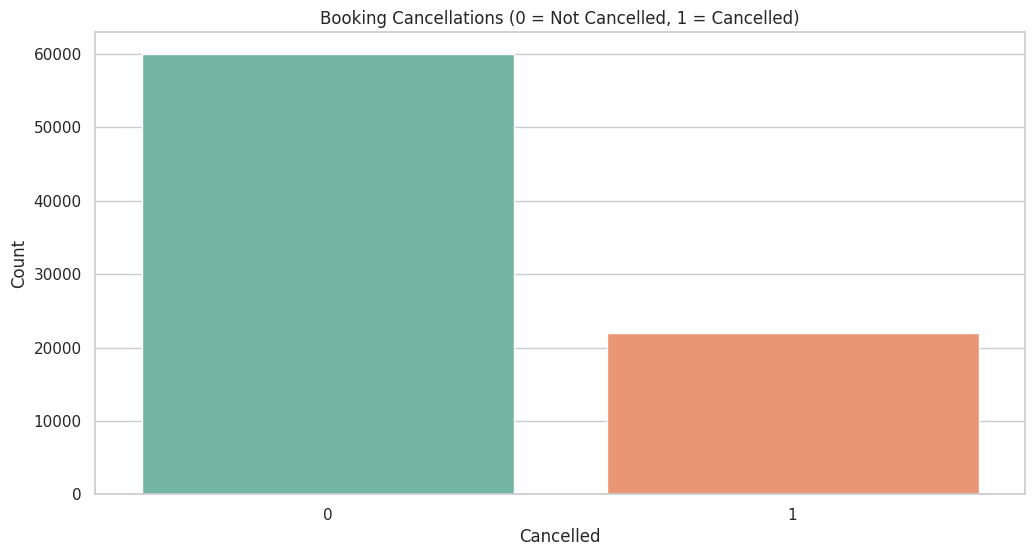

 Cancellation Rate: 26.78%


In [11]:
# Distribution of cancellations (Future-safe version)
sns.countplot(data=df, x='is_cancelled', hue='is_cancelled', palette='Set2', legend=False)
plt.title("Booking Cancellations (0 = Not Cancelled, 1 = Cancelled)")
plt.xlabel("Cancelled")
plt.ylabel("Count")
plt.show()

# Cancellation rate
cancel_rate = df['is_cancelled'].mean() * 100
print(f" Cancellation Rate: {cancel_rate:.2f}%")

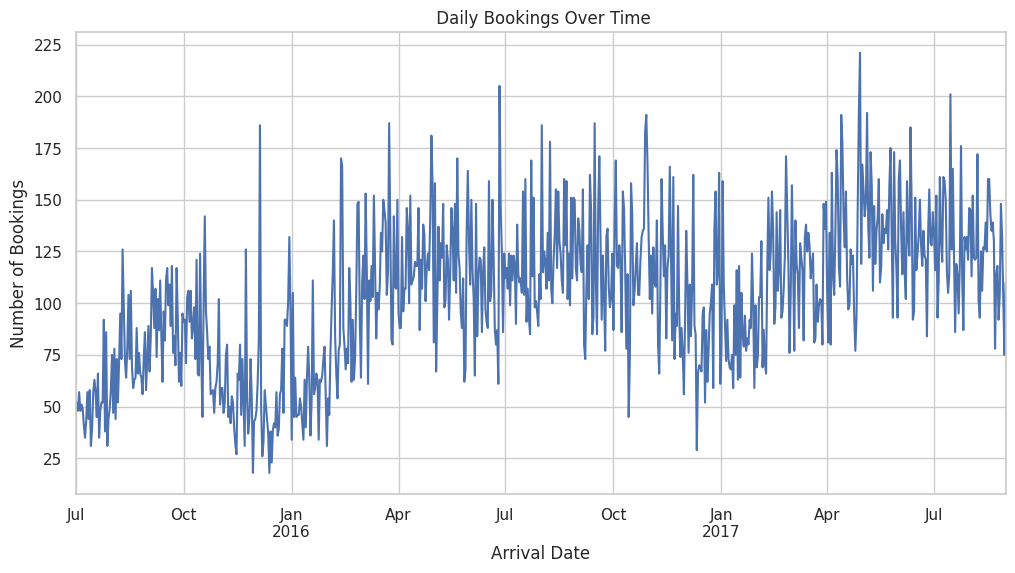

In [12]:
# Convert arrival_date to datetime if not already done
if 'arrival_date' in df.columns:
    bookings_by_date = df.groupby('arrival_date').size()
    bookings_by_date.plot(title=' Daily Bookings Over Time')
    plt.xlabel("Arrival Date")
    plt.ylabel("Number of Bookings")
    plt.show()

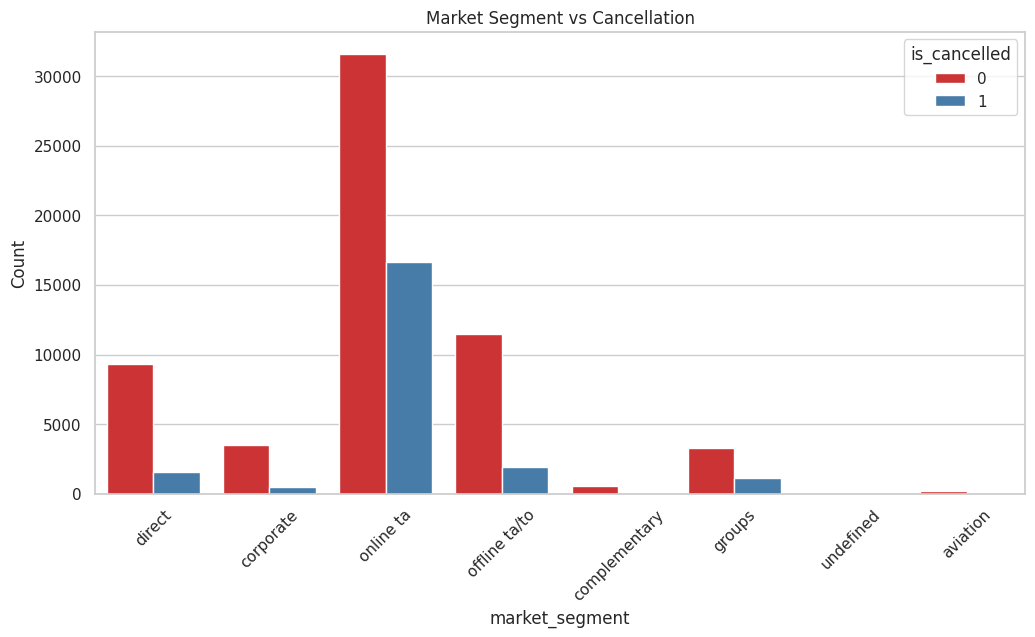

In [13]:
if 'market_segment' in df.columns:
    sns.countplot(data=df, x='market_segment', hue='is_cancelled', palette='Set1')
    plt.title("Market Segment vs Cancellation")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()

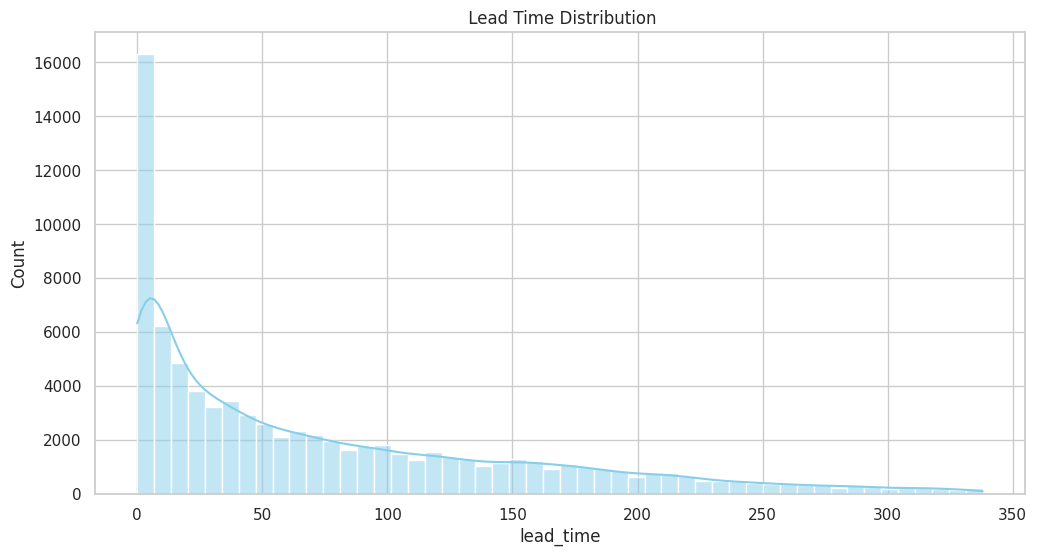

In [14]:
# Lead time distribution
sns.histplot(data=df, x='lead_time', bins=50, kde=True, color='skyblue')
plt.title(" Lead Time Distribution")
plt.show()

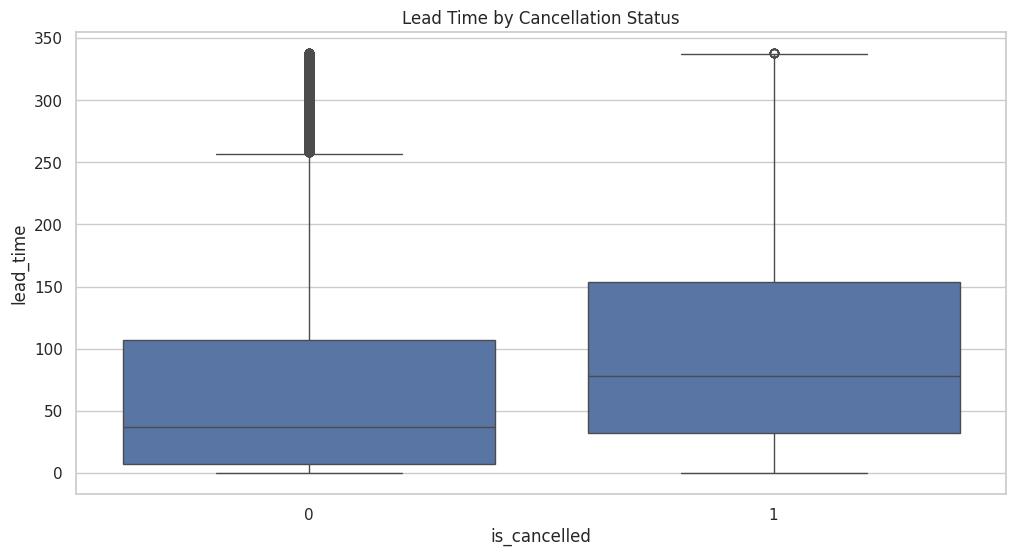

In [15]:
# Lead time vs cancellation
sns.boxplot(x='is_cancelled', y='lead_time', data=df)
plt.title("Lead Time by Cancellation Status")
plt.show()

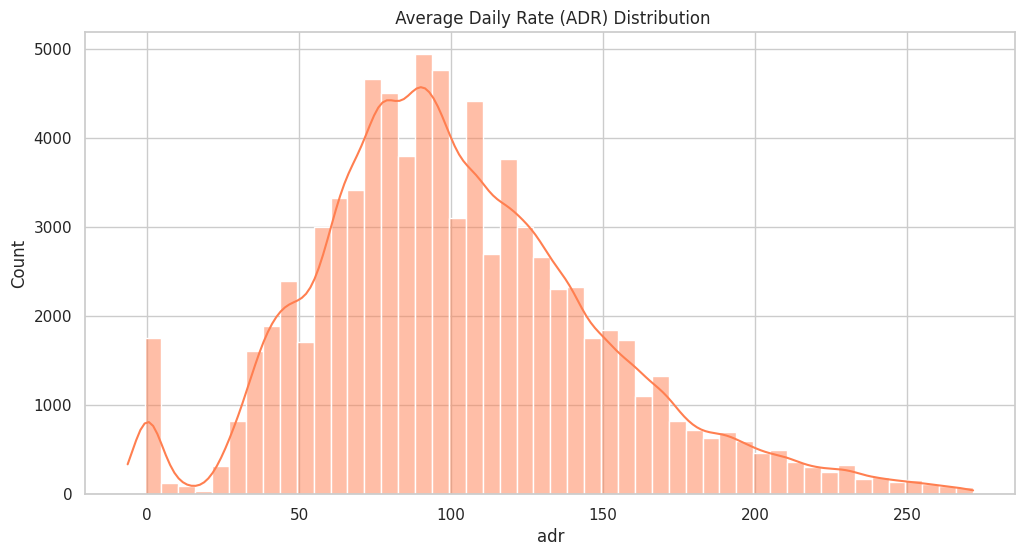

In [16]:
# Distribution of ADR
sns.histplot(data=df, x='adr', bins=50, kde=True, color='coral')
plt.title(" Average Daily Rate (ADR) Distribution")
plt.show()

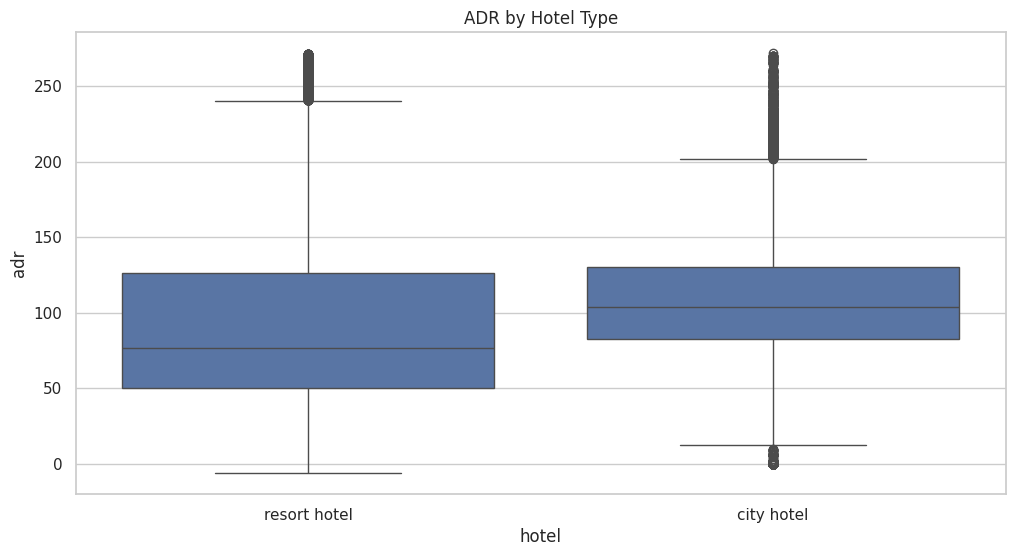

In [17]:
# ADR by hotel type
if 'hotel' in df.columns:
    sns.boxplot(x='hotel', y='adr', data=df)
    plt.title("ADR by Hotel Type")
    plt.show()

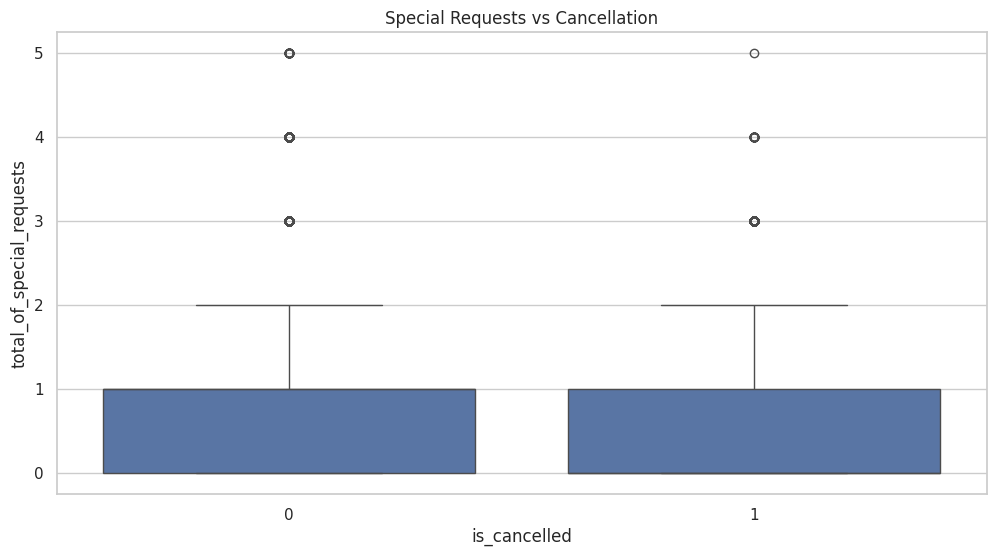

In [18]:
if 'total_of_special_requests' in df.columns:
    sns.boxplot(x='is_cancelled', y='total_of_special_requests', data=df)
    plt.title("Special Requests vs Cancellation")
    plt.show()

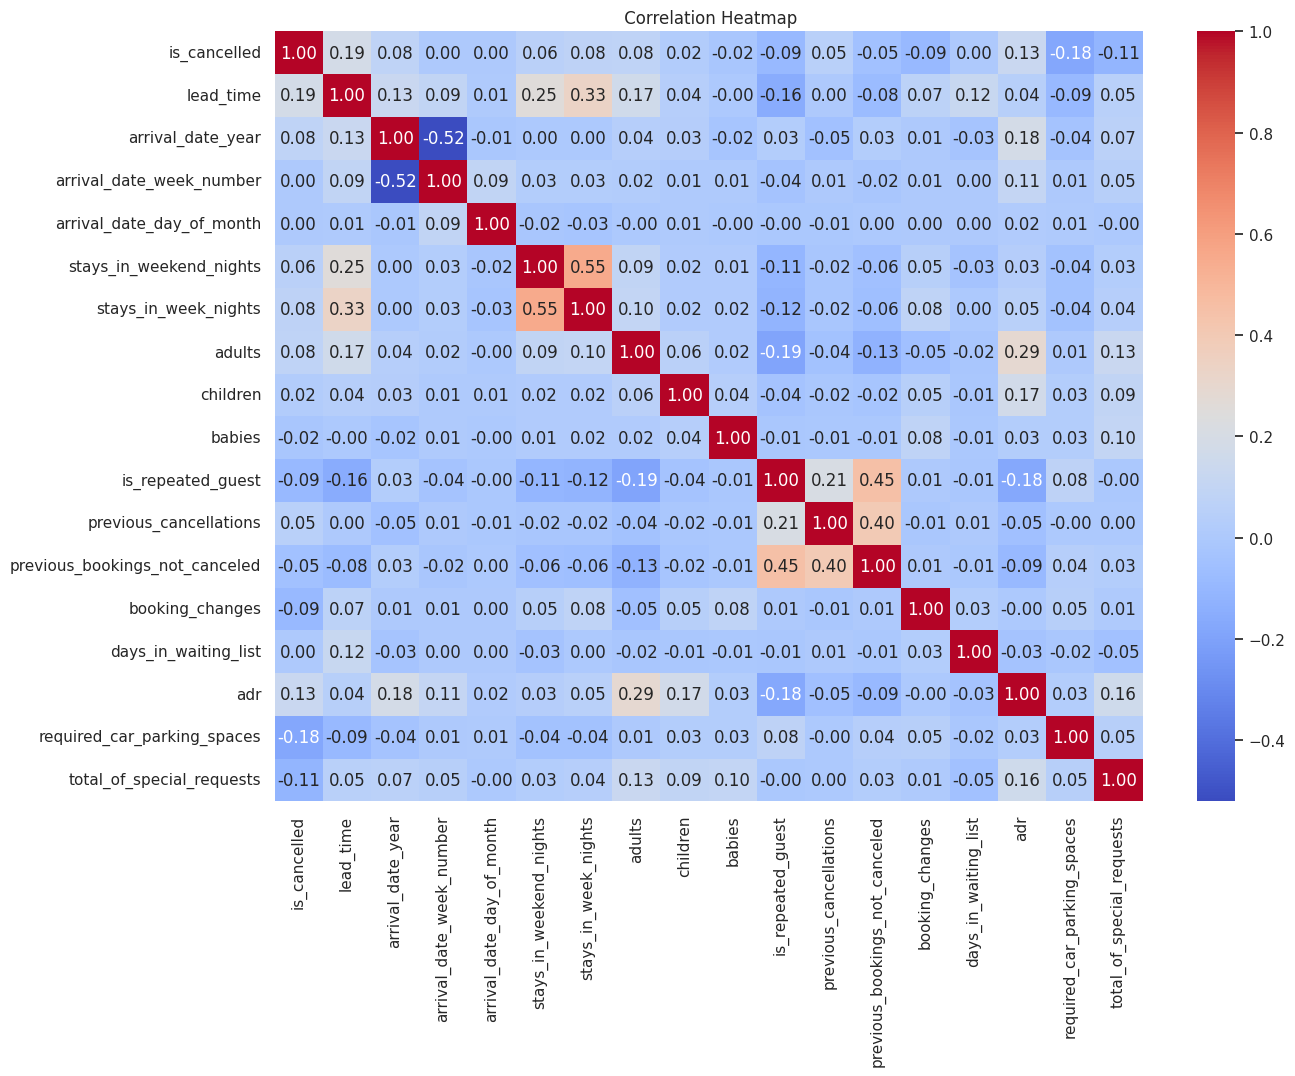

In [19]:
# Only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title(" Correlation Heatmap")
plt.show()